## Physical implementation of a qubit device

In [69]:
%matplotlib inline
import numpy as np; pi = np.pi
import networkx as nx
from qutip import *
from qutip.qip.device import *
from qutip.qip.operations import *
from qutip.qip.circuit import QubitCircuit
from cvqaoa import *
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2

#### Generate a random Max-Cut problem

In [30]:
N = 5
graph = nx.generators.random_graphs.erdos_renyi_graph(n=N,p=0.5)
obj = MaxCut(graph)
cost = obj.cost

#### Define the CARB-gate

In [31]:
def carb(theta):
    """
    Quantum object representing the CARB gate.

    Returns
    -------
    carb_gate : qobj
        Quantum object representation of CARB gate

    Examples
    --------

    """
    return Qobj([[np.exp(-1j*theta/2), 0, 0, 0],
                 [0, np.exp(1j*theta/2), 0, 0],
                 [0, 0, np.exp(1j*theta/2), 0],
                 [0, 0, 0, np.exp(-1j*theta/2)]],
                dims=[[2, 2], [2, 2]])

#### Circuit Setup

In [32]:
# Iteration level
p = 1
gamma = np.random.rand() * np.pi
beta = np.random.rand() * np.pi / 2

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)
qc.user_gates = {"CARB": carb}

for u,v in graph.edges:
    qc.add_gate("CARB", targets = [u,v], arg_value = 2*gamma)
for j in range(N):
    qc.add_gate("RX", j, None, 2*beta)

In [39]:
ket0 = basis(2,0)
ket1 = basis(2,1)
init_state = tensor([(ket0 + ket1).unit() for i in range(N)])
U_list = qc.propagators()
U = gate_sequence_product(U_list) # matrix representation of the quantum circuit
target_state = U*init_state
target_rho = ket2dm(target_state)

#### Load circuit onto qubit processor

In [41]:
T1 = 10
qp = QubitProcessor(N=N,T1=T1)
qp.load_circuit(qc)
t_total = 0
for pulse in qp.pulses:
    if pulse.tlist[-1] > t_total:
        t_total = pulse.tlist[-1]
print("Total time: %s 1/K" % round(t_total,1))

Total time: 16.0 1/K


(<Figure size 864x432 with 1 Axes>,
 <AxesSubplot:xlabel='Time (1/K)', ylabel='Amplitude (K)'>)

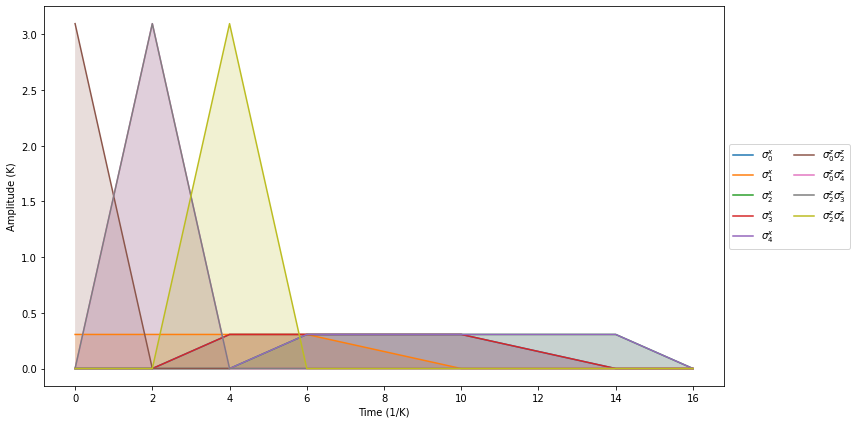

In [44]:
qp.plot_pulses()

#### Run simulation

In [45]:
ket0 = basis(2,0); ket1 = basis(2,1) # computational basis
plus = (ket0+ket1).unit()
init_state = tensor([plus for i in range(N)]) # initial state
result = qp.run_state(init_state = init_state)
final_state = result.states[-1]
if final_state.type == "ket":
    rho_final = ket2dm(final_state)
else:
    rho_final = final_state

#### Calculate the fidelity

In [47]:
f = fidelity(rho_final,target_rho)
print("Fidelity =",round(f,5))

Fidelity = 0.41471


#### Calculate the success probability and the approximation ratio

In [48]:
cost_min = min(cost)
z = np.argwhere(cost == cost_min)

In [49]:
success = np.real(sum(rho_final[int(z[i,0]),int(z[i,0])] for i in range(len(z))))*100
print("Success Probability = %s %%" %round(success,2))

Success Probability = 38.17 %


In [60]:
# expectation value
expval = np.trace(cost*rho_final.full()).real
approxr = expval / cost_min
print("Approximation Ratio = %s" %round(approxr,3))

Approximation Ratio = 0.671


#### Decoherence
In Processor, decoherence noise is simulated by adding collapse operator into the Lindbladian equation. For single-qubit decoherence, it is equivalent to applying random bit flip and phase flip error after applying the quantum gate. For qubit relaxation, one can simply specify the $T1$ and $T2$ time for the device or for each qubit. Here we assume the qubit system has a drift Hamiltonian $H_d=\hbar\omega\sigma_z$, for simplicity, we let $\hbar\omega=10$

In [61]:
a = destroy(2)
initial_state = basis(2,1)
plus_state = (basis(2,1) + basis(2,0)).unit()
tlist = np.linspace(0, 3000, 100)
H_d = 0.*sigmaz()

#### Decay time T1
The $T_1$ relaxation time describes the strength of amplitude damping and can be described, in a two-level system, by a collapse operator $1/\sqrt{T_1}a$, where a is the annihilation operator. This leads to an exponential decay of the population of excited states proportional to $\exp(−t/T_1)$. This amplitude damping can be simulated by specifying the attribute t1 of the processor

In [64]:
from qutip.qip.pulse import Pulse
T1 = 1500
processor = QubitProcessor(1,T1=T1)
# creat a dummpy pulse that has no Hamiltonian, but only a tlist.
processor.add_pulse(Pulse(None, None, tlist=tlist, coeff=False))
result = processor.run_state(init_state=initial_state, e_ops=[a.dag()*a])

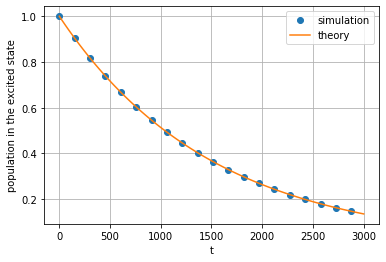

In [65]:
fig, ax = plt.subplots()
ax.plot(tlist[0: -1: 5], result.expect[0][0: -1: 5], 'o', label="simulation")
ax.plot(tlist, np.exp(-1./T1*tlist), label="theory")
ax.set_xlabel("t")
ax.set_ylabel("population in the excited state")
ax.legend()
plt.grid()

#### Decay time $T_2$
The $T_2$ time describes the dephasing process. Here one has to be careful that the amplitude damping channel characterized by $T_1$ will also lead to a dephasing proportional to $\exp(-t/2T_1)$. To make sure that the overall phase dampling is $exp(-t/T_2)$, the processor (internally) uses an collapse operator $\frac{1}{\sqrt{2*T'_2}} \sigma_z$ with $\frac{1}{T'_2}+\frac{1}{2T_1}=\frac{1}{T_2}$ to simulate the dephasing. (This also indicates that $T_2 \leqslant 2T_1$)

Usually, the $T_2$ time is measured by the Ramsey experiment, where the qubit starts from the excited state, undergoes a $\pi/2$ pulse, proceeds for a time $t$, and measured after another $\pi/2$ pulse. For simplicity, here we directly calculate the expectation value of $\rm{H}\circ a^\dagger a \circ\rm{H}$, where $\rm{H}$ denotes the Hadamard transformation. This is equivalent to measure the population of $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$. The envelope should follow an exponential decay characterized by $T_2$.

In [67]:
tlist = np.arange(0.00, 2.02, 0.02)
H_d = 10*sigmaz()
T1 = 1.
T2 = .5
processor = QubitProcessor(1, T1=T1, T2=0.5)
processor.add_drift(H_d, 0)
processor.add_pulse(Pulse(None, None, tlist=tlist, coeff=False))
Hadamard = hadamard_transform(1)
result = processor.run_state(init_state=plus_state, e_ops=[Hadamard*a.dag()*a*Hadamard])

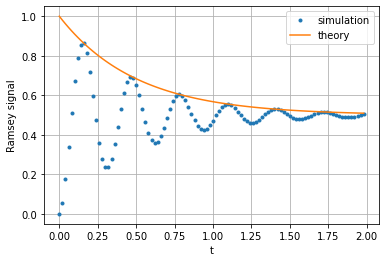

In [68]:
fig, ax = plt.subplots()
# detail about lenght of tlist needs to be fixed
ax.plot(tlist[:-1], result.expect[0][:-1], '.', label="simulation")
ax.plot(tlist[:-1], np.exp(-1./(T2)*tlist[:-1])*0.5 + 0.5, label="theory")
plt.xlabel("t")
plt.ylabel("Ramsey signal")
plt.legend()
ax.grid()